In [1]:
# Jacob, addition
import nltk
nltk.download('stopwords')

# originals
import pandas as pd
import numpy as np
import csv 
import string
import nltk 
import re 
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import sys
import warnings
from os import path
import ast
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, average_precision_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import jaccard_score
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from skmultilearn.adapt import BRkNNaClassifier
from sklearn.linear_model import RidgeClassifierCV
import pickle

pd.options.display.max_seq_items = 2000
pd.options.display.max_colwidth = 90
pd.options.display.max_rows = 999




[nltk_data] Downloading package stopwords to /Users/fd252/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# -*- coding: utf-8 -*-
# Importing required Library
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

In [3]:


def create_dataset(n_sample=1000):
    ''' 
    Create an unevenly distributed sample data set multilabel  
    classification using make_classification function
    
    args
    nsample: int, Number of sample to be created
    
    return
    X: pandas.DataFrame, feature vector dataframe with 10 features 
    y: pandas.DataFrame, target vector dataframe with 5 labels
    '''
    X, y = make_classification(n_classes=5, class_sep=2, 
                           weights=[0.1,0.025, 0.205, 0.008, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=10, n_clusters_per_class=1, n_samples=1000, random_state=10)
    y = pd.get_dummies(y, prefix='class')
    return pd.DataFrame(X), y

def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        #print(column)
        irpl[column] = df[columns[column]].value_counts()[1]
        #print(irpl[column])
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
    """
    give the index of all tail_label rows
    args
    df: pandas.DataFrame, target label df from which index for tail label has to identified
    
    return
    index: list, a list containing index number of all the tail label
    """
    tail_labels = get_tail_label(df)
    index = set()
    for tail_label in tail_labels:
        sub_index = set(df[df[tail_label]==1].index)
        index = index.union(sub_index)
    return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    #print(y)
    index = get_index(y)
    #print(index)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=3,metric='euclidean',algorithm='kd_tree').fit(X) #n_neighbors=3 mockito and n_neighbors=5 all
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target



In [4]:
#organizing data_frame to issue order
def organize():

    try:
        #data = pd.read_csv('file1.csv',skiprows=line)
        data_classes = pd.read_csv( binaryBodyTitle, header = 0, sep=';')
    except:
        print ('number of columns varying. Skipping bad lines!')
        data_classes = pd.read_csv(binaryBodyTitle, header = 0, sep=';', error_bad_lines=False)

    # OBS!!!!!
    #line 62 mockito was deleted wrong number of columns!
    #line 1923 rxjava was deleted wrong number of columns!
    
    
    ## Code implemented below before modifications by Jacob ##
    # del data_classes['prIssue']
    # del data_classes['issueTitle']
    # del data_classes['issueBody']
    
    # these renames are listed in the order that the original name appears in the list of headers
    # coming in from the binary file
    # data_classes.rename(columns={ 'pr': 'prNumber',                                   
    #                               'Title': 'prTitle',                                 
    #                               'Body': 'prBody',                                   
    #                               'issue': 'issueNumber',                             
    #                               'issueComments': 'prComments',                      
    #                               'issueTitleLink': 'issueTitle',                     
    #                               'issueBodyLink': 'issueBody',                       
    #                               'issueCommentsLink': 'issue_Comments',              
    #                               'Comments': 'prCodeReviewComments' }, inplace=True) 
    
    # categories = data_classes.columns.values.tolist()
    
    
    # this list must match the headers coming in from the binary file in name and order, including
    # with the renames above
    # data_classes = data_classes[[ 'pr', 'Util', 'NLP', 'APM', 'Network', 'DB', 'Interpreter', 'Logging', 
    #                               'Thread', 'DataStructure', 'i18n', 'DevOps', 'Logic',  
    #                               'Microservices', 'ML', 'Test', 'Search', 'IO', 'UI', 'Parser', 'Security',
    #                               'Cloud', 'BigData', 'App', 'GIS', 'Title', 'Body', 'prIssue', 'issue', 
    #                               'issueTitle', 'issueBody', 'issueComments', 'issueTitleLink', 'issueBodyLink', 
    #                               'issueCommentsLink', 'isPR', 'isTrain', 'commitMessage', 'Comments']]  


    ## Code above after modifications by Jacob ##
    # these renames are listed in the order that the original name appears in the list of headers
    # coming in from the binary file
    data_classes.rename(columns={ 'pr': 'prNumber',                                   
                                  'Title': 'prTitle',                                 
                                  'Body': 'prBody',                                   
                                  'issue': 'issueNumber',                             
                                  'issueComments': 'prComments',                      
                                  #'issueTitleLink': 'issueTitle',                     
                                  #'issueBodyLink': 'issueBody',                       
                                  'issueCommentsLink': 'issue_Comments',              
                                  'Comments': 'prCodeReviewComments',
                                #'Data Structure': 'DataStructure',
                            #'Big Data': 'BigData'
                                }, inplace=True) 
    
    
    # DANGER! old experiments may nott have all this labels!!!
    if 'Utility' not in data_classes.columns:
        data_classes['Utility'] = 0
    if 'Natural Language Processing' not in data_classes.columns:
        data_classes['Natural Language Processing'] = 0
    if 'Application Performance Manager' not in data_classes.columns:
        data_classes['Application Performance Manager'] = 0
    if 'Network' not in data_classes.columns:
        data_classes['Network'] = 0
    if 'Database' not in data_classes.columns:
        data_classes['Database'] = 0
    if 'Interpreter' not in data_classes.columns:
        data_classes['Interpreter'] = 0
    if 'Multi Thread' not in data_classes.columns:
        data_classes['Multi Thread'] = 0
    if 'Error Handling' not in data_classes.columns:
        data_classes['Error Handling'] = 0
    if 'Logging' not in data_classes.columns:
        data_classes['Logging'] = 0
    if 'Language' not in data_classes.columns:
        data_classes['Language'] = 0
    if 'Data Structure' not in data_classes.columns:
        data_classes['Data Structure'] = 0
    if 'Software Development and IT Operations' not in data_classes.columns:
        data_classes['Software Development and IT Operations'] = 0
    if 'Internationalization' not in data_classes.columns:
        data_classes['Internationalization'] = 0
    if 'Setup' not in data_classes.columns:
        data_classes['Setup'] = 0
    if 'Logic' not in data_classes.columns:
        data_classes['Logic'] = 0
    if 'Microservices' not in data_classes.columns:
        data_classes['Microservices'] = 0
    if 'Machine Learning' not in data_classes.columns:
        data_classes['Machine Learning'] = 0
    if 'Test' not in data_classes.columns:
        data_classes['Test'] = 0
    if 'Search' not in data_classes.columns:
        data_classes['Search'] = 0
    if 'Input and Output' not in data_classes.columns:
        data_classes['Input and Output'] = 0
    if 'User Interface' not in data_classes.columns:
        data_classes['User Interface'] = 0
    if 'Parser' not in data_classes.columns:
        data_classes['Parser'] = 0
    if 'Security' not in data_classes.columns:
        data_classes['Security'] = 0
    if 'Cloud' not in data_classes.columns:
        data_classes['Cloud'] = 0
    if 'Big Data' not in data_classes.columns:
        data_classes['Big Data'] = 0
    if 'Event Handling' not in data_classes.columns:
        data_classes['Event Handling'] = 0
    if 'Application' not in data_classes.columns:
        data_classes['Application'] = 0
    if 'Geographic Information System' not in data_classes.columns:
        data_classes['Geographic Information System'] = 0
    if 'Multimedia' not in data_classes.columns:
        data_classes['Multimedia'] = 0
    if 'Computer Graphics' not in data_classes.columns:
        data_classes['Computer Graphics'] = 0
    if 'Operation System' not in data_classes.columns:
        data_classes['Operation System'] = 0

    # standardize labels 
    data_classes.rename(columns={ 'Utility': 'Util',
                                 'Natural Language Processing':'NLP',
                                 'Application Performance Manager':'APM',
                                 'Network':'Network',
                                 'Database':'DB',
                                 'Interpreter':'Interpreter',
                                 'Multi Thread': 'Multi Thread',
                                 'Error Handling':'Error Handling',
                                 'Logging':'Logging',
                                 'Language':'Lang',
                                 'Data Structure':'Data Structure',
                                 'Software Development and IT Operations':'DevOps',
                                 'Internationalization':'i18n',
                                 'Setup':'Setup',
                                 'Logic':'Logic',
                                 'Microservices':'Microservices',
                                 'Machine Learning':'ML',
                                 'Test':'Test',
                                 'Search':'Search',
                                 'Input and Output':'IO',
                                 'User Interface':'UI',
                                 'Parser':'Parser',
                                 'Security':'Security',
                                 'Cloud':'Cloud',
                                 'Big Data':'Big Data',
                                 'Event Handling':'Event Handling',
                                 'Application':'App',
                                 'Geographic Information System':'GIS',
                                 'Multimedia':'Multimedia',
                                 'Operation System':'OS',
                                 'Computer Graphics':'CG'
                                 }, inplace=True) 
    
    categories = data_classes.columns.values.tolist()
    print('categories:',categories)
    
    # this list must match the headers coming in from the binary file in name and order, including
    # with the renames above
#    data_classes = data_classes[[ 'prNumber', 'Util', 'NLP', 'APM', 'Network', 'DB', 'Interpreter', 'Logging', 
#                                  'Thread', 'DataStructure', 'i18n', 'DevOps', 'Logic',
#                                  'Microservices', 'ML', 'Test', 'Search', 'IO', 'UI', 'Parser', 'Security',
#                                  'Cloud', 'BigData', 'App', 'GIS', 'prTitle', 'prBody', 'prIssue', 'issueNumber', 
#                                  'issueTitle', 'issueBody', 'prComments', 'issueTitleLink', 'issueBodyLink', 
#                                  'issue_Comments', 'isPR', 'isTrain', 'commitMessage', 'prCodeReviewComments']]    

    data_classes = data_classes[ categories]    

    
    data_classes['issueNumber'] = data_classes['issueNumber'].astype('Int64')
    print('before filtering out empty classes',data_classes.shape)
    
    #find rows with parse error
    data_classes_error = data_classes.loc[pd.isnull(data_classes.loc[:,'Util'])]
    print('rows filtered out empty classes (parse error)',data_classes_error.shape)
    
    col_data_classes = len(data_classes.columns)

    if (len(data_classes_error) > 0):
        data_classes_fixed= data_classes_error.iloc[:,0].str.split(';', expand=True)
        print('rows fixed after new parse - empty classes (parse error)',data_classes_fixed.shape)

        col_data_classes_fixed = len(data_classes_fixed.columns)
        
        #removing rows with problems 
        data_classes.dropna(subset = ["Util"], inplace=True)
        print('after filtering out empty classes',data_classes.shape)
        
        print('len columns data_classes:',col_data_classes)
        print('len columns data_classes_fixed:',col_data_classes_fixed)
        
        if (col_data_classes == col_data_classes_fixed):
            
            #names =['prNumber','DB','Interpreter','Logging','Thread','DataStructure','DevOps','i18n','Logic',
            #        'Microservices','ML','Test','Search','IO','UI','Parser','Security','Cloud','BigData','App',
            #        'GIS','Util','NLP','APM','Network','prTitle','prBody','prIssue','issueNumber','issueTitle',
            #        'issueBody','prComments','issueTitleLink','issueBodyLink','issue_Comments','isPR','isTrain',
            #        'commitMessage','prCodeReviewComments']                     
            #data_classes_fixed.columns = names
            data_classes_fixed.columns = categories

            #drop data with error after parsing
            index_names = data_classes_fixed[ (data_classes_fixed['Util'] != '0') & (data_classes_fixed['Util'] != '1') |
                                     (data_classes_fixed['NLP'] != '0') & (data_classes_fixed['NLP'] != '1') |
                                     (data_classes_fixed['APM'] != '0') & (data_classes_fixed['APM'] != '1') |
                                     (data_classes_fixed['Network'] != '0') & (data_classes_fixed['Network'] != '1') |
                                     (data_classes_fixed['DB'] != '0') & (data_classes_fixed['DB'] != '1') |
                                     (data_classes_fixed['Interpreter'] != '0') & (data_classes_fixed['Interpreter'] != '1') |
                                     (data_classes_fixed['Logging'] != '0') & (data_classes_fixed['Logging'] != '1') |
                                     (data_classes_fixed['Thread'] != '0') & (data_classes_fixed['Thread'] != '1') |
                                     (data_classes_fixed['Data Structure'] != '0') & (data_classes_fixed['Data Structure'] != '1') |
                                     (data_classes_fixed['i18n'] != '0') & (data_classes_fixed['i18n'] != '1') |

                                     (data_classes_fixed['DevOps'] != '0') & (data_classes_fixed['DevOps'] != '1') |
                                     (data_classes_fixed['Logic'] != '0') & (data_classes_fixed['Logic'] != '1') |
                                     (data_classes_fixed['Microservices'] != '0') & (data_classes_fixed['Microservices'] != '1') |
                                     (data_classes_fixed['ML'] != '0') & (data_classes_fixed['ML'] != '1') |
                                     (data_classes_fixed['Test'] != '0') & (data_classes_fixed['Test'] != '1') |
                                     (data_classes_fixed['Search'] != '0') & (data_classes_fixed['Search'] != '1') |
                                     (data_classes_fixed['IO'] != '0') & (data_classes_fixed['IO'] != '1') |
                                     (data_classes_fixed['UI'] != '0') & (data_classes_fixed['UI'] != '1') |
                                     (data_classes_fixed['Parser'] != '0') & (data_classes_fixed['Parser'] != '1') |
                                     (data_classes_fixed['Security'] != '0') & (data_classes_fixed['Security'] != '1') |
                                     (data_classes_fixed['Cloud'] != '0') & (data_classes_fixed['Cloud'] != '1') |
                                     (data_classes_fixed['Big Data'] != '0') & (data_classes_fixed['Big Data'] != '1') |
                                     (data_classes_fixed['App'] != '0') & (data_classes_fixed['App'] != '1') |
                                     (data_classes_fixed['GIS'] != '0') & (data_classes_fixed['GIS'] != '1') |
                                     (data_classes_fixed['Error Handling'] != '0') & (data_classes_fixed['Error Handling'] != '1') |
                                     (data_classes_fixed['Event Handling'] != '0') & (data_classes_fixed['Event Handling'] != '1') |
                                     (data_classes_fixed['Lang'] != '0') & (data_classes_fixed['Lang'] != '1') |
                                     (data_classes_fixed['Setup'] != '0') & (data_classes_fixed['Setup'] != '1') |
                                     (data_classes_fixed['Multimedia'] != '0') & (data_classes_fixed['Multimedia'] != '1') |
                                     (data_classes_fixed['OS'] != '0') & (data_classes_fixed['OS'] != '1') |
                                     (data_classes_fixed['CG'] != '0') & (data_classes_fixed['CG'] != '1')
                                            ].index

            # drop these given row
            # indexes from dataFrame
            data_classes_fixed.drop(index_names, inplace = True)
            print('data fixed after dropping parse fix errors',data_classes_fixed.shape)

            #back to float
            data_classes_fixed['Util'] = data_classes_fixed['Util'].astype(str).astype('Float64')
            data_classes_fixed['NLP'] = data_classes_fixed['NLP'].astype(str).astype('Float64')
            data_classes_fixed['APM'] = data_classes_fixed['APM'].astype(str).astype('Float64')
            data_classes_fixed['Network'] = data_classes_fixed['Network'].astype(str).astype('Float64')
            data_classes_fixed['DB'] = data_classes_fixed['DB'].astype(str).astype('Float64')
            data_classes_fixed['Interpreter'] = data_classes_fixed['Interpreter'].astype(str).astype('Float64')
            data_classes_fixed['Logging'] = data_classes_fixed['Logging'].astype(str).astype('Float64')
            data_classes_fixed['Thread'] = data_classes_fixed['Thread'].astype(str).astype('Float64')
            data_classes_fixed['Data Structure'] = data_classes_fixed['Data Structure'].astype(str).astype('Float64')
            data_classes_fixed['i18n'] = data_classes_fixed['i18n'].astype(str).astype('Float64')
            data_classes_fixed['DevOps'] = data_classes_fixed['DevOps'].astype(str).astype('Float64')
            data_classes_fixed['Logic'] = data_classes_fixed['Logic'].astype(str).astype('Float64')
            data_classes_fixed['Microservices'] = data_classes_fixed['Microservices'].astype(str).astype('Float64')
            data_classes_fixed['ML'] = data_classes_fixed['ML'].astype(str).astype('Float64')
            data_classes_fixed['Test'] = data_classes_fixed['Test'].astype(str).astype('Float64')
            data_classes_fixed['Search'] = data_classes_fixed['Search'].astype(str).astype('Float64')
            data_classes_fixed['IO'] = data_classes_fixed['IO'].astype(str).astype('Float64')
            data_classes_fixed['UI'] = data_classes_fixed['UI'].astype(str).astype('Float64')
            data_classes_fixed['Parser'] = data_classes_fixed['Parser'].astype(str).astype('Float64')
            data_classes_fixed['Security'] = data_classes_fixed['Security'].astype(str).astype('Float64')
            data_classes_fixed['Cloud'] = data_classes_fixed['Cloud'].astype(str).astype('Float64')
            data_classes_fixed['Big Data'] = data_classes_fixed['Big Data'].astype(str).astype('Float64')
            data_classes_fixed['App'] = data_classes_fixed['App'].astype(str).astype('Float64')
            data_classes_fixed['GIS'] = data_classes_fixed['GIS'].astype(str).astype('Float64')
            data_classes_fixed['Error Handling'] = data_classes_fixed['Error Handling'].astype(str).astype('Float64')
            data_classes_fixed['Event Handling'] = data_classes_fixed['Event Handling'].astype(str).astype('Float64')
            data_classes_fixed['Lang'] = data_classes_fixed['Lang'].astype(str).astype('Float64')
            data_classes_fixed['Setup'] = data_classes_fixed['Setup'].astype(str).astype('Float64')
            data_classes_fixed['Multimedia'] = data_classes_fixed['Multimedia'].astype(str).astype('Float64')
            data_classes_fixed['OS'] = data_classes_fixed['OS'].astype(str).astype('Float64')
            data_classes_fixed['CG'] = data_classes_fixed['CG'].astype(str).astype('Float64')

            # appending fixed rows
            data_classes_new = data_classes.append(data_classes_fixed)
            print('after appending fixed rows',data_classes_new.shape)

            return data_classes_new
        
        else:
            print('fixing parse errors failed')

            return data_classes
    
    else:
        
        print('no parse errors found')
        return data_classes

In [5]:
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None
pd.options.display.max_seq_items = None
pd.set_option('display.max_columns', None)  

In [6]:
#data_classes = organize()

In [7]:
#data_classes.columns

In [8]:
#data_classes

In [9]:
#data_classes["prTitle"]

In [10]:
#data_classes["issueTitle"]

In [11]:
#data_classes["issueTitleLink"]

In [12]:
#data_classes["prBody"]

In [13]:
#data_classes["issueBody"]

In [14]:
#data_classes["issueBodyLink"]

In [15]:
#Filtering issues with PRs
def filtering(data_classes):
    
    print('before filtering out isTrain == 0',data_classes.shape)

    IssuePRDataset = data_classes[data_classes["isTrain"] == 0]
    
    print('after filtering out isTrain == 0',IssuePRDataset.shape)

    #invalid number of issue = NaN
    # IssuePRDataset = IssuePRDataset.drop([1805])

    categories = IssuePRDataset.columns.values.tolist()
    
    return categories, IssuePRDataset

In [16]:
#categories, IssuePRDataset = filtering(data_classes)

In [17]:
#IssuePRDataset.head()

In [18]:
# RQ1.a - o quão sensível o resultado é em relação ao algoritmo? 
#vários algoritmos - BinaryRelevance
#todas as palavras, bootstrap, unigram 
#somente o título
def dataset_config(IssuePRDataset):
    # ORIGINAL
    # data_test1 = IssuePRDataset[['issueNumber','prNumber','issueTitle','Google Common', 
    #                              'Test', 'SO', 'IO', 'UI', 'Network', 'Security', 
    #                              'OpenOffice Documents', 'Database', 'Utils', 'PDF', 
    #                              'Logging', 'Latex']].copy()
    
    # WORKS WITH NEW INPUTS
    # data_test1 = IssuePRDataset[['issueNumber','prNumber','issueTitle', 'Test','IO', 'UI', 'Network', 'Security', 'Logging' ]].copy() 

    data_test1 = IssuePRDataset[[ 'issueNumber','prNumber','issueTitle','issueBody', 'prTitle', 'prBody',
                             'issueTitleLink','issueBodyLink','commitMessage','prComments',
                             'Util','NLP','APM','Network','DB','Interpreter','Error Handling','Logging',
                                 'Lang','Data Structure','DevOps','i18n','Setup','Logic','Microservices',
                                 'ML','Test','Search','IO','UI','Parser','Security','Cloud','Big Data',
                                 'Event Handling','App','GIS','Multimedia','CG' ]].copy()
    #print(type(data_test1))
    #data_test1['corpus'] = IssuePRDataset['issueTitle'] + IssuePRDataset['issueBody']
    data_test1["corpus"] = data_test1["issueBody"].map(str)

    # rxjava 2489 terms
    # mockito 598
    # presto 4
    # guava 1140
    # jabref 740
    
    #data_test1["corpus"] = data_test1["issueTitle"].map(str) + ' ' + data_test1["issueBody"].map(str) + ' ' + data_test1["prTitle"].map(str) + ' ' + data_test1["prBody"].map(str)
    # rxjava 3002 terms
    
    del data_test1["issueTitle"]
    del data_test1["issueBody"]
    del data_test1["prTitle"]
    del data_test1["prBody"]
    del data_test1["issueTitleLink"]
    del data_test1["issueBodyLink"]
    del data_test1["commitMessage"]
    del data_test1["prComments"]

    print('before filtering out empty corpus',data_test1.shape)
    data_test1.dropna(subset = ["corpus"], inplace=True)
    
    data_test1['corpus'] = data_test1['corpus'].str.replace("nan",' ')
    print('after filtering out empty corpus',data_test1.shape)

    #removing utils because we won't to predict a so simple API that is basically used in all PRs
    #del data_test1["Util"]

    data_test1 = data_test1.reset_index(drop=True)
    
    return data_test1

In [19]:
#preprocessing text

#We first convert the comments to lower-case 
#then use custom made functions to remove html-tags, punctuation and non-alphabetic characters from the TitleBody.

def clean_data(data_test1):
    if not sys.warnoptions:
        warnings.simplefilter("ignore")

    def cleanHtml(sentence):
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, ' ', str(sentence))
        return cleantext

    def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
        cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
        cleaned = cleaned.strip()
        cleaned = cleaned.replace("\n"," ")
        return cleaned

    def keepAlpha(sentence):
        alpha_sent = ""
        for word in sentence.split():
            alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
            alpha_sent += alpha_word
            alpha_sent += " "
        alpha_sent = alpha_sent.strip()
        return alpha_sent

    #function pra remover palavras com menos de 3 tokens

    data_test1['corpus'] = data_test1['corpus'].str.lower()
    data_test1['corpus'] = data_test1['corpus'].apply(cleanHtml)
    data_test1['corpus'] = data_test1['corpus'].apply(cleanPunc)
    data_test1['corpus'] = data_test1['corpus'].apply(keepAlpha)
    
    return data_test1


In [20]:
#### removing stopwords

def remove_stop_words():
    stop_words = set(stopwords.words('english'))
    stop_words.update(['nan','pr','zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within','jabref','org','github','com','md','https','ad','changelog','','joelparkerhenderson','localizationupd',' localizationupd','localizationupd ','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the','Mr', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'])
    #stop_words.update(['i', 'me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the","Mr", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

    re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

    return re_stop_words

In [21]:
def removeStopWords(sentence, re_stop_words):
    #global re_stop_words
    #print(sentence)
    return re_stop_words.sub(" ", sentence)

#removing words with less than 3 characters
#data_classes['titleBody'] = data_classes['titleBody'].str.findall('\w{3,}').str.join(' ')

In [22]:
def apply_stem(data_test1):
    stemmer = SnowballStemmer("english")
    
    def stemming(sentence):
        stemSentence = ""
        for word in sentence.split():
            stem = stemmer.stem(word)
            stemSentence += stem
            stemSentence += " "
        stemSentence = stemSentence.strip()
        return stemSentence
    
    data_test1['corpus'] = data_test1['corpus'].apply(stemming)
    #print(data_test1['corpus'])
    
    return data_test1


In [23]:
#TF-ID
def run_tf_idf(data, configurationTFIDF, num_feature, tfIDFoutputFile):
    #we need to text max_feature with 10, 20, 25, 50 
    #, max_features=num_feature
    vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range = configurationTFIDF, max_features=num_feature)
        
    tf_idf_results = vectorizer.fit_transform(data['corpus'])

    features = vectorizer.get_feature_names()

    #print(features)

    scores = (tf_idf_results.toarray())
    output_tf_idf = pd.DataFrame(scores)
    
    output_tf_idf = pd.concat([data['issueNumber'], output_tf_idf], axis=1)

    output_tf_idf.to_csv(tfIDFoutputFile, encoding='utf-8', header=False, index=False, sep=',')


    # remove words occuring less than 5 times
    #tfidf = TfidfVectorizer(min_df=5)
    #you can also remove common words:

    # remove words occuring in more than half the documents
    #tfidf = TfidfVectorizer(max_df=0.5)
    #you can also remove stopwords like this:
    

In [24]:
#analyzing frequency of TOP 50 terms

def analyze_top(data, termFrequencyTop50):
    docs = data['corpus'].tolist()

    cv = CountVectorizer()
    cv_fit=cv.fit_transform(docs)

    #print(cv.get_feature_names())
    #print(cv_fit.toarray())

    word_list = cv.get_feature_names()   

    count_list = cv_fit.toarray().sum(axis=0)
    term_frequency = dict(zip(word_list,count_list))

    a = sorted(term_frequency.items(), key=lambda x: x[1], reverse=True) 
    
    print('SIZE OF TERMS', len(a))
    
    top50 = a[:50]
    df_frequency = pd.DataFrame(top50, columns =['term', 'frequency'])  
    #df_frequency = pd.DataFrame(a, columns =['term', 'frequency'])  


    print(df_frequency)
    #print(a)

    df_frequency.to_csv(termFrequencyTop50, encoding='utf-8', header=False, index=False, sep=',')

    sns.set(font_scale = 2)
    plt.figure(figsize=(18,17))
    plt.xticks(rotation=90)
    plt.title("Frequency of terms ")
    plt.ylabel('term', fontsize=20)
    plt.xlabel('frequency', fontsize=20)
    ax = sns.barplot(x="frequency", y="term", data=df_frequency)
    
    return docs, a


In [25]:
#merging features TF-IDF with data_frame
def merging(data_test1, tfIDFoutputFile):
    feature = pd.read_csv(tfIDFoutputFile, header=None, sep=",")
    feature.rename(columns={0: 'issueNumber'}, inplace=True)

    data_classifier = data_test1.join(feature, lsuffix='issueNumber', rsuffix='issueNumber')

    categories = data_classifier.columns.values.tolist()
    
    return data_classifier, categories


In [26]:
def eval_metrics(predictions, probabilities, y_test):
    
    y_pred = predictions.values
    y_proba = probabilities.values

    #receiving the y_test true value from each pull request
    y_true = y_test.to_numpy()

    print("Accuracy Score")
    acc_ml = accuracy_score(y_true, y_pred)
    print(acc_ml)

    print("---------")
    print("")

    print("Accuracy Score not normalized")
    acc_score = accuracy_score(y_true, y_pred, normalize=False)
    print(acc_score)

    print("---------")
    print("")

    print("zero_one_loss")
    zeroOne = zero_one_loss(y_true, y_pred)
    print(zeroOne)

    print("---------")
    print("")

    print("Fmeasure Score")
    fmeasure_score = f1_score(y_true,y_pred, average='micro')
    #fmeasure_score = f1_score(y_true,y_pred, average='macro')
    print(fmeasure_score)

    print("---------")
    print("")

    #AUC-PR
    print("AUC-PR")
    pr_score = average_precision_score(y_true,y_proba,average='micro')
    print(pr_score)
    #pr_score = average_precision_score(y_true,y_proba,average='macro')

    print("---------")
    print("")


    print("hamming loss average")
    hamming_loss = skm.hamming_loss(y_true, y_pred)
    print(hamming_loss)

    print("---------")
    print("")

    print("Jaccard samples")
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    print(jaccard_score_samples)

    print("---------")
    print("")


    print("Jaccard macro")
    jaccard_macro = jaccard_score(y_true, y_pred, average='micro')
    print(jaccard_macro)
    #jaccard_score(y_true, y_pred, average=None)

    print("---------")
    print("")

    return y_true, y_proba, y_pred, acc_ml, acc_score, zeroOne, fmeasure_score, pr_score, hamming_loss, jaccard_score_samples, jaccard_macro

In [27]:
def plot_classes(probability, y_true, y_test):
    precision = dict()
    recall = dict()
    average_precision = dict()

    n_classes = y_test.shape[1]

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], probability[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], probability[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),probability.ravel())

    average_precision["micro"] = average_precision_score(y_true, probability, average="micro")

    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))


In [28]:
import io
def confusion_matrix(y_true, y_pred, confusionMatrix, i, proj_name, labels):

    data = multilabel_confusion_matrix(y_true, y_pred)
    #print('CM:',type(data))
    
    #labels = ['Util', 'NLP', 'APM', 'Network', 'DB', 'Interpreter',
    #                              'Logging', 'Thread', 'Data Structure', 'i18n', 
    #                              'DevOps', 'Logic', 'interpreter', 'Microservices', 'ML',
    #                              'Test', 'Search', 'IO', 'UI', 'Parser', 'Security',
    #                              'Cloud', 'Big Data', 'App', 'GIS']        

    metrics = pd.DataFrame()
    line = []
    dataLine = ""
    dataLine = "Label, TN, FP, FN, TP"
    line.append((dataLine))

    #for j in range (0,12):
    #print('CM:', len(labels))
    #print('Data:', data.shape)
    for j in range (0,len(labels)):
        #print(j)
        row = data[j]
        dataLine=""
        dataLine = labels[j] 
        #print(dataLine)
        for x in np.nditer(row):
            dataLine = dataLine + "," + str(x)
            #print(dataLine)
        line.append((dataLine))
        #print(line)
        
        metrics = pd.DataFrame(line)
    
    print(line)
    metrics.to_csv(confusionMatrix + str(i) +'.csv' , encoding='utf-8', header=True, index=False , sep=',')
    

In [29]:
#build the model 

def build_model(test_type):
    clf = BinaryRelevance(classifier=RandomForestClassifier(criterion='entropy',max_depth= 50, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 50), require_dense = [False, True])


    if test_type == "DecisionTree":
        clf = BinaryRelevance(classifier=DecisionTreeClassifier(), require_dense = [False, True])
        #clf = ClassifierChain(classifier=DecisionTreeClassifier(), require_dense = [False, True])
    if test_type == "LogisticRegression":
        clf = BinaryRelevance(classifier=LogisticRegression(random_state=0), require_dense = [False, True])
        #clf = ClassifierChain(classifier=LogisticRegression(random_state=0), require_dense = [False, True])
    if test_type == "RandomForest": 
        clf = BinaryRelevance(classifier=RandomForestClassifier(criterion='entropy',max_depth= 50, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 50), require_dense = [False, True])
        #clf = ClassifierChain(classifier=RandomForestClassifier(criterion='entropy',max_depth= 50, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 50), require_dense = [False, True])
    if test_type == "MLPClassifier":
        clf = BinaryRelevance(classifier=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1), require_dense = [False, True])
        #clf = ClassifierChain(classifier=MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1), require_dense = [False, True])
    if test_type == "MLkNN":
        clf = BinaryRelevance(MLkNN(k=3))
        #clf = ClassifierChain(classifier=MLkNN(k=3))

    #This three works without probability
    if test_type == "LinearSVC":
        clf = BinaryRelevance(classifier=LinearSVC(), require_dense = [False, True])
    if test_type == "GaussianNB":
        clf = BinaryRelevance(classifier=GaussianNB(), require_dense = [False, True])
    if test_type == "RidgeClassifierCV":
        clf = BinaryRelevance(classifier=RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]), require_dense = [False, True]) 
    if test_type == "BRkNNaClassifier":
        clf = BinaryRelevance(BRkNNaClassifier(k=3))

        
    return clf

In [30]:
def save_metrics(y_true, y_pred, acc_ml,acc_score,zeroOne,pr_score,hamming_loss,jaccard_score_samples,jaccard_macro, modelMatrix, metrics_by_class, i, configurationTFIDF ,num_feature ,stop_word ,size_test,test_type, proj_name, names, report):

    line=[] 
    # line to csv report file
    
    prec, rec, fscore, sup = precision_recall_fscore_support(y_true,y_pred, average='micro')


    arr = [acc_ml,acc_score,zeroOne,pr_score,hamming_loss,jaccard_score_samples,jaccard_macro,prec,rec, fscore]
    columns = ['Accuracy','Acc-Score','zero_one_loss','AUC-PR','hamming loss average','Jaccard samples','Jaccard macro','Precision','Recall','Fmeasure']
  
    df_metrics2 = pd.DataFrame([arr],columns=columns)
    print(df_metrics2)

    print("---------")
    print("")

    x = precision_recall_fscore_support(y_true,y_pred, average=None)
    print("")
    print("")

    df_metrics_by_class = pd.DataFrame.from_records(x, columns=names, index=['precision','recall','f-measure','samples_tested'])
    print(df_metrics_by_class)

    print("---------")
    print("")

    df_metrics2.to_csv(modelMatrix+str(i)+'.csv', encoding='utf-8', header=True, index=False, sep=',')    

    df_metrics_by_class.to_csv(metrics_by_class+str(i)+'.csv', encoding='utf-8', header=True, index=False, sep=',')    

    dataLine = ""
    dataLine = "tf-IDFMin, tf-IDFMax, #_TopTerms,Stop_Word,Train/Test_Size,Algorithm,Accuracy_Score,Accuracy_Score_not_normalized,zero_one_loss, AUC-PR,hamming_loss_avg,Jaccard_samples,Jaccard_macro,Precision,Recall,Fmeasure_Score, i"
    line.append((dataLine))
    dataLine =  str(configurationTFIDF) + "," + str(num_feature) + "," + stop_word + "," + str(size_test) + "," + str(test_type) + "," + str(acc_ml) + ","+ str(acc_score) + ","+ str(zeroOne) + "," + str(pr_score) + ","+ str(hamming_loss) + ","+ str(jaccard_score_samples) + ","+ str(jaccard_macro)+"," + str(prec)+","+str(rec)+","+str(fscore)+","+str(i) 
    line.append((dataLine))
    print(line)

    metrics = pd.DataFrame(line)
    metrics.to_csv(report+str(i)+'.csv', encoding='utf-8', header=False, index=False, sep=',')    
    #np.savetxt(r'./experiment/report'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+str(i)+'.txt', metrics.values, fmt='%s', delimiter=',')
    #np.savetxt(r'./experiment/new/'+proj_name+'/report'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+str(i)+'.txt', metrics.values, fmt='%s', delimiter=',')

    return prec, rec, fscore, sup

In [31]:
import datetime

def persist_data(configurationTFIDF ,num_feature , stop_word , size_test , test_type , acc_ml , 
           acc_score , zeroOne , pr_score, hamming_loss, jaccard_score_samples, 
           jaccard_macro , prec , rec, fscore, i):
    now = datetime.datetime.now()
    date_str = now.strftime("%Y-%m-%d %H:%M:%S")
    templateData = pd.read_csv(dfTeste_output, sep=',')
    
    #print ("Current date and time : ")
    #print (now.strftime("%Y-%m-%d %H:%M:%S"))
    headerdf = ['date_time','tf-IDF', '#_TopTerms','Stop_Word','Train/Test_Size','Algorithm','Accuracy_Score',
                'Accuracy_Score_not_normalized','zero_one_loss', 'AUC-PR','hamming_loss_avg','Jaccard_samples',
                'Jaccard_macro','Precision','Recall','Fmeasure_Score','i']


    tup = ( date_str,str(configurationTFIDF) ,str(num_feature) , stop_word , str(size_test) , str(test_type) , str(acc_ml) , 
           str(acc_score) , str(zeroOne) , str(pr_score) , str(hamming_loss) , str(jaccard_score_samples) , 
           str(jaccard_macro) , str(prec) , str(rec) , str(fscore) ,str(i))

    #print("tupla:", tup)
    #print(len(tup))

    list_tup  = [ date_str,str(configurationTFIDF) ,str(num_feature) , stop_word , str(size_test) , str(test_type) , str(acc_ml) , 
           str(acc_score) , str(zeroOne) , str(pr_score) , str(hamming_loss) , str(jaccard_score_samples) , 
           str(jaccard_macro) , str(prec) , str(rec) , str(fscore) ,str(i)]


    dfTeste = pd.DataFrame.from_records(data=[tup], columns=[headerdf])

    data_list = templateData.values.tolist()
    data_list.append(list_tup)
    new_data = pd.DataFrame(data_list)  
    #for row in templateData.itertuples():
    #    print(row)

    new_data.to_csv( dfTeste_output, encoding='utf-8', index=False, sep=',', header=headerdf)  
    

In [32]:
def run_split(dataset_smote, test_type, confusionMatrix, modelMatrix, metrics_by_class, configurationTFIDF ,num_feature ,stop_word ,size_test, proj_name, final_columns, report, predictions_result, probabilities_result, classifierFeatureInput):
    train = []
    test = []

    max_f = final_columns[len(final_columns)-1]
    min_f = final_columns[0]
    print('min:',min_f,' max:',max_f)
    
    #our_X = data_classifier.iloc[:,16:916]
    #our_y = data_classifier.iloc[:,2:14]
    #dataset = pd.concat([our_y,our_X], axis=1)
    #dataset_smote = pd.concat([dataset, y_X_res], axis=0)
    
    #data = data_smote
    #X = dataset_smote
    #dataset_smote.to_csv('dataset_smote.csv', encoding='utf-8', sep=',')

    size_features = len(dataset_smote.columns)

    #data.to_csv(classifierFeatureInput+'train'+str(i)+'.csv', encoding='utf-8', sep=',')    

    X = dataset_smote.iloc[:,len(final_columns):size_features] # all
    y = dataset_smote.loc[:,min_f :max_f] # all           

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    train.append(X_train)
    test.append(y_train)
    
    #data = dataset_smote.iloc[train]
    data = dataset_smote.loc[y_test.index]

    print("================y_train\n=========================")

    print('y_train:',y_train)
    print(y_train.columns)
    print(y_train.shape)

    #print("================X_train\n=========================")

    print(X_train.columns)
    print(X_train.shape)

    print("================y_test\n=========================")

    print('y_test:',y_test)
    print(y_test.columns)
    print(y_test.shape)

    #print("================X_test\n=========================")

    print(X_test.columns)
    print(X_test.shape)
    #print(len(X_test),len(X_test.columns))

    categories = y_test.columns.values.tolist()
    ids = y_test.index

    classifier_setup = build_model(test_type)

    clf = classifier_setup

    try:
        clf.fit(X_train,y_train)

        # save the model to disk
        filename = predictions_result+'_finalized_model.sav'
        pickle.dump(clf, open(filename, 'wb'))

        predict = clf.predict(X_test).toarray()
        try:
            probability = clf.predict_proba(X_test).toarray()
            #print (type(probability))
            #print(probability.shape[0])
            #print(probability.shape[1])
            print("prob works")
        except:
            print("prob doens't work")
            probability = myArr = np.zeros((len(X_test),len(y_test.columns))) # rows = X_test & columns = y_test !!!

        predictions = pd.DataFrame(predict, index=ids, columns=categories) # with header
        probabilities = pd.DataFrame(probability, index=ids, columns=categories) # with header

        predictions.to_csv(predictions_result+'.csv', encoding='utf-8', sep=',')    
        probabilities.to_csv(probabilities_result+'.csv', encoding='utf-8', sep=',')    

        data.to_csv('data_test.csv', encoding='utf-8', sep=',')
        pred = pd.merge(data, predictions, how="right",left_index=True, right_index=True)
        pred.to_csv('predictions_result_data.csv', encoding='utf-8', sep=',')

        data_merge = data.loc[:,'prNumber':'App']
        mergedDf = predictions.merge(data_merge, left_index=True, right_index=True)
        mergedDf.to_csv(predictions_result+'_data_merge.csv' , encoding='utf-8', header=True, index=False , sep=',')

        #y_pred = predictions.values
        #y_proba = probabilities.values
        #i = 10 -> no shuffleSplit!!
        i = 10
        
        y_true = y_test.to_numpy()

        y_true, y_proba, y_pred, acc_ml, acc_score, zeroOne, fmeasure_score, pr_score, hamming_loss, jaccard_score_samples, jaccard_macro = eval_metrics(predictions, probabilities, y_test)

        plot_classes(probability, y_true, y_test)

        confusion_matrix(y_true, y_pred, confusionMatrix, i, proj_name, final_columns)

        prec, rec, fscore, sup = save_metrics(y_true, y_pred, acc_ml,acc_score,zeroOne,pr_score,hamming_loss,jaccard_score_samples,jaccard_macro, modelMatrix, metrics_by_class, i, configurationTFIDF ,num_feature ,stop_word ,size_test,test_type, proj_name, final_columns, report)

        persist_data(configurationTFIDF ,num_feature , stop_word , size_test , test_type , acc_ml , 
           acc_score , zeroOne , pr_score, hamming_loss, jaccard_score_samples, 
           jaccard_macro , prec , rec, fscore, i)
    except: 
        print ("fit error? all one class?")
        #print(y_train.columns)
        print(y_train.shape)




In [35]:
# project
proj_name       = "jabref50_2"
working_dir     = "/Users/fd252/OneDrive/Research4/MSRExt/"
#labels = ['Util', 'NLP', 'APM', 'Network', 'DB', 'Interpreter', 'Logging', 
#                                  'Thread', 'DataStructure', 'i18n', 'DevOps', 'Logic',
#                                  'Microservices', 'ML', 'Test', 'Search', 'IO', 'UI', 'Parser', 'Security',
#                                  'Cloud', 'BigData', 'App', 'GIS']
            
labels = ['Util','NLP','APM','Network','DB','Interpreter','Thread','Error Handling','Logging','Lang','Data Structure',
          'DevOps','i18n','Setup','Logic','Microservices','ML','Test','Search','IO','UI',
          'Parser','Security','Cloud','Big Data','Event Handling','App','GIS','Multimedia','CG']
#labels = ['Utility','Natural Language Processing','Application Performance Manager','Network','Database',
#          'Interpreter','Multi Thread','Error Handling','Logging','Language','Data Structure',
#          'Software Development and IT Operations','Internationalization','Setup','Logic','Microservices',
#          'Machine Learning','Test','Search','Input and Output','User Interface','Parser','Security',
#          'Cloud','Big Data','Event Handling','Application','Geographic Information System','Multimedia','Computer Graphics',
#           ]
# input
binaryBodyTitle = working_dir + "OSSPRMapper/outputs/" + proj_name + '/' + proj_name + '_' + "binaryBodyTitle.csv"
print( "Input Binary File: " + binaryBodyTitle )


# output
output_root_dir = working_dir + "H1/experiment/new/"  
out_path        = output_root_dir + proj_name + '/' + proj_name + '_'

print( "Output path      : " + out_path )

dfTeste_output  = out_path + "dfTeste.csv"
print( "dfTeste output   : " + dfTeste_output )
# UNUSED: loggingFile  = out_path + "TitleBody3GramTFIDF.txt"

# !! see In[45] for the definitions of these output paths. They are kept here for posterity but must be defined there
# tfIDFoutputFile        = out_path + 'tfIDFoutputFile'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
# classifierFeatureInput = out_path + 'train_file_test'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
# termFrequencyTop50     = out_path + 'termFrequencyTop50'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
# predictions_result     = out_path + 'predict_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
# probabilities_result   = out_path + 'probability_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
# modelMatrix            = out_path + 'modelMatrix'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
# metrics_by_class       = out_path + 'metrics_By_Class'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'  
# confusionMatrix        = out_path + 'CM'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type) 

#number of shuffles (folds)
splits=10

#defining paths
# loggingFile = './experiment//TitleBody3GramTFIDF.txt'
# binaryBodyTitle = './experiment/binaryBodyTitle.csv'
template = output_root_dir + proj_name + '/' + 'dfTeste.csv'

configurationTFIDFList = [(1,1)]
#configurationTFIDFList = [(1,1),(2,2)]
#configurationTFIDFList = [(1,1),(2,2),(3,3),(4,4)]
#configurationTFIDFList = [(2,2),(3,3),(4,4)]
#num_featureList = [25,50,100,500,1000,2500,5000]
#num_featureList = [90,179,358,716,895,1432,2864,5728]
num_featureList = [895] #MSR


#num_featureList = [740] #jabref body 739 v2
#num_featureList = [1140] #guava body  1141 v2
#num_featureList = [4] #presto body 4 v2
#num_featureList = [598] #mockito body 597 v2
#num_featureList = [2489] #rxjava body 2436 v2
#num_featureList = [2676] #jabref50 body 2676 v2

#num_featureList = [228] #jabref title
#num_featureList = [6] #guava title
#num_featureList = [7] #presto title
#num_featureList = [216] #mockito title
#num_featureList = [800] #rxjava title
#num_featureList = [838] #jabref50 title

#num_featureList = [794] #jabref title+body
#num_featureList = [1143] #guava title+body
#num_featureList = [10] #presto title+body
#num_featureList = [654] #mockito title+body
#num_featureList = [2615] #rxjava title+body
#num_featureList = [2818] #jabref50 title+body

#num_featureList = [1336] #jabref title+body+comments
#num_featureList = [1204] #guava title+body+comments
#num_featureList = [10] #presto title+body+comments
#num_featureList = [974] #mockito title+body+comments
#num_featureList = [3269] #rxjava title+body+comments
#num_featureList = [5622] #jabref50 title+body+comments

size_testList = [0.2]
#size_testList = [0.2,0.3]
#size_testList = [0.2,0.3,0.4]
stop_wordList = ["Yes"]
#test_typeList = ["RandomForest","DecisionTree","LogisticRegression","MLPClassifier","MLkNN"]
#test_typeList = ["RandomForest","DecisionTree","MLPClassifier","MLkNN"]
#test_typeList = ["RandomForest","DecisionTree","MLPClassifier"]
#test_typeList = ["RandomForest","LogisticRegression","DecisionTree"]
test_typeList = ["RandomForest"]

#examples
#configurationTFIDFList = [(1,1),(2,2)]
#num_featureList = [25,50]
#size_testList = [0.2,0.3]
#stop_wordList = ["Yes","No"]
#test_typeList = ["RandomForest","DecisionTree"]

configurationTFIDF=(1,1)
num_feature=895

size_test=0.2

#stop_word = stop_wordList[i]
stop_word = "Yes"

test_type = "RandomForest"
# dont forget to have the file dfTeste.csv ready in the files folder only with the header!

def __main__():
    
    print("----------------") 
    now = datetime.datetime.now()

    
    print ("Current date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))

    print(proj_name)
    print("----------------") 

    # getting length of list 
    lengthT = len(configurationTFIDFList) 
    lengthF = len(num_featureList) 
    lengthS = len(size_testList)
    lengthY = len(test_typeList)
    
    data_classes = organize()
    print( data_classes.columns )
    
    categories, IssuePRDataset = filtering(data_classes)
    IssuePRDataset.to_csv(out_path + 'isTrainZero.csv' , encoding='utf-8', header=True, index=False , sep=',')


    data_test1 = dataset_config(IssuePRDataset)
    data_test1 = clean_data(data_test1)
    print('################# data_test1 after fixing')
    #print(data_test1.columns)

#   print('1',data_test1['corpus'])

    re_stop_words = remove_stop_words()
    data_test1['corpus'] = data_test1['corpus'].apply(removeStopWords, re_stop_words=re_stop_words)
    data = data_test1
#   print('2',data_test1['corpus'])
    data_test1 = apply_stem(data)
    
    print("================COLUMNS BEFORE DELETION\n=========================")
    print('data shape:',data_test1.shape)
    nrows = data_test1.shape[0]
    nrows_threshold = nrows * 0.9
    print('threshold:', nrows_threshold)
    print(list(data_test1.columns))
    first = labels[0]
    print('1o label:',first)
    last = labels [len(labels)-1]
    print('last label:',last)
    no_occurences = data_test1.loc[:,first:last].sum()
    #print(type(no_occurences))
    print("================LABELS\n=========================")

    print(no_occurences)  #df.loc[:, 'Score'].sum()

    last = ' '
    setup_first = False 
    num_with_values = 0
    final_columns = []
    for i, v in no_occurences.items(): 
        #print('i;',i)
        #print('v;',v)
        #if v == 0:
        if v < 2:
            #print ('deleting columns with < 2. ', i, 'occurences:', v)
            del data_test1[i]

        else:
            if v > nrows_threshold:
                #print ('deleting columns with > ', nrows_threshold, '.', i, 'occurences:', v)
                del data_test1[i]

            else:
                if not setup_first:
                    #if v != 0:
                    #if v > 1:
                    first = i
                    print('first element > 0', first)
                    setup_first = True

                final_columns.append(i)
                num_with_values = num_with_values + 1
                last = i
    print('last element > 0:', last)
            
    print('classes range:', first,' - ', last, 'total:',num_with_values)
    print('final classes (columns):', final_columns)

    print("================COLUMNS AFTER DELETION\n=========================")
    print('data shape:',data_test1.shape)
    #data_test1.to_csv('data_classes.csv', encoding='utf-8', sep=',')    

    if num_with_values < 2:
        print('Less than 2 valid labels:', num_with_values, ' exiting...')
        print('data columns:',data_test1.columns)
        sys.exit()

    # Iterating the index 
    # same as 'for i in range(len(list))' 
    for f in range(lengthF): 
        print("----------------") 
        print(num_featureList[f]) 
        print("----------------") 

        num_feature=num_featureList[f]

        for t in range(lengthT): 
            print("----------------") 
            print(num_featureList[f]) 
            print(configurationTFIDFList[t])
            print("----------------") 

            configurationTFIDF=configurationTFIDFList[t]

            tfIDFoutputFile        = out_path + 'tfIDFoutputFile'+ str(configurationTFIDF) + str(num_feature) + stop_word +'.csv'
            termFrequencyTop50     = out_path + 'termFrequencyTop50'+ str(configurationTFIDF) + str(num_feature) + stop_word + '.csv'
            docs, a = analyze_top(data_test1, termFrequencyTop50)

            print('num features discovered automaticaly', len(a))
#           print('3',data_test1['corpus'])
            #run_tf_idf(data_test1, configurationTFIDF, num_feature, tfIDFoutputFile)
            run_tf_idf(data_test1, configurationTFIDF, len(a), tfIDFoutputFile)
#           print('4',data_test1['corpus'])                 

            data_classifier, categories = merging(data_test1, tfIDFoutputFile)     
            #data_test1.to_csv('data_classifier.csv', encoding='utf-8', sep=',')    

            for s in range(lengthS):
                print("----------------") 
                print(num_featureList[f]) 
                print(configurationTFIDFList[t]) 
                print(size_testList[s]) 
                print("----------------") 

                size_test=size_testList[s]

                for y in range(lengthY):
                    print("----------------") 
                    print(num_featureList[f]) 
                    print(configurationTFIDFList[t]) 
                    print(size_testList[s]) 
                    print(test_typeList[y]) 
                    print("----------------") 

                    #stop_word = stop_wordList[i]
                    #stop_word = "Yes"

                    test_type = test_typeList[y]
                    
                    # tfIDFoutputFile = './experiment/tfIDFoutputFile'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    # classifierFeatureInput='./experiment/train_file_test'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    # termFrequencyTop50 = './experiment/termFrequencyTop50'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    # predictions_result = './experiment/predict_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    # probabilities_result = './experiment/probability_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    # modelMatrix = './experiment/modelMatrix'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'
                    # metrics_by_class = './experiment/metrics_By_Class'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)+'.csv'  
                    # confusionMatrix = './experiment/CM'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type) 
                    classifierFeatureInput = out_path + 'train_file_test'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)
                    predictions_result     = out_path + 'predict_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)
                    probabilities_result   = out_path + 'probability_file_'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)
                    modelMatrix            = out_path + 'modelMatrix'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)
                    metrics_by_class       = out_path + 'metrics_By_Class'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type)  
                    confusionMatrix        = out_path + 'CM'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type) 
                    report                 = out_path + 'report'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type) 
                    dataset_smote_out      = out_path + 'dataset_smote'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type) 
                    dataset_smote_out_pr   = out_path + 'dataset_smote_pr'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type) 
                    dataset_merged         = out_path + 'predictions_merged_pr'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type) 
                    data_classifier_out     = out_path + 'data_classifier'+ str(configurationTFIDF) + str(num_feature) + stop_word + str(size_test)+ str(test_type) 

                    data_classifier.to_csv(data_classifier_out+'.csv', encoding='utf-8', sep=',')    

                    # some rows are with nan. df = df[df['my_var'].notna()] ?
                    # or should we change by blank spaces?
 
                    #SMOTE)
                    #print("data classifier",list(data_classifier.columns))
                    
                    #SMOTE
                    limit = len(data_classifier.columns)
                    
                    print('column limit:', limit)
                                        
                    our_X = data_classifier.iloc[:,num_with_values+4:limit] # TF-IDF probabilities all
                    our_y = data_classifier.iloc[:,2:num_with_values+2] # Expert labels all
                    #our_y = data_classifier.iloc[:,1:num_with_values+2] # Expert labels all + prNumber

                    print("================our_y AFTER DELETION\n=========================")
                    print(our_y.shape)
                    #print(list(our_y.columns))
                    #our_y.to_csv(classifierFeatureInput+'_our_y.csv', encoding='utf-8', sep=',')    
   
                    print("================our_X AFTER DELETION\n=========================")
                    print(our_X.shape)
                    #print(our_X.columns)

                    dataset = pd.concat([our_y,our_X], axis=1)
                    #print("dataset to smote",list(dataset.columns))
                    #dataset.shape

                    try:

                        X_sub, y_sub = get_minority_instace(our_X, our_y)   #Getting minority instance of that datframe


                        X_res,y_res =MLSMOTE(X_sub, y_sub, 100)     #Applying MLSMOTE to augment the dataframe

                        y_X_res = pd.concat([y_res,X_res], axis=1)
                        #y_X_res.shape

                        print("================SMOTE \n=========================")
                        dataset_smote = pd.concat([dataset, y_X_res], axis=0)

                    except: 
                        
                        print("================SMOTE Failed\n=========================")

                        dataset_smote = dataset

                    
                    print('dataset after smote:',dataset_smote.shape)
                    #print('dataset columns after smote:',list(dataset_smote.columns))
                    
                    #dataset_smote.to_csv(dataset_smote_out+'.csv', encoding='utf-8', sep=',')    
                    
                    # get prNumber back
                    prsDF = data_classifier.iloc[:,1:2]
                    dataset_smote_prs = prsDF.merge(dataset_smote, left_index=True, right_index=True)
                    
                    # do we need to create fake prs for those did not merge? 
                    # what happens if smote creates index for predictions that match real index?
                    # do we need to ignore them?
                    
                    print('dataset after smote with prs:',dataset_smote_prs.shape)
                    #print('dataset columns after smote with prs:',list(dataset_smote_prs.columns))
                    dataset_smote_prs.to_csv(dataset_smote_out_pr+'.csv', encoding='utf-8', sep=',')    
                    
                    #run_split(dataset_smote, test_type, confusionMatrix, modelMatrix, metrics_by_class, configurationTFIDF ,num_feature ,stop_word ,size_test, proj_name, final_columns, report, predictions_result, probabilities_result, classifierFeatureInput)
                    run_split(dataset_smote_prs, test_type, confusionMatrix, modelMatrix, metrics_by_class, configurationTFIDF ,len(a) ,stop_word ,size_test, proj_name, final_columns, report, predictions_result, probabilities_result, classifierFeatureInput)
                    
    print("----------------") 
    print( "Operations complete!")
    now = datetime.datetime.now()

    
    print ("Current date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    print("----------------") 



Input Binary File: /Users/fd252/OneDrive/Research4/MSRExt/OSSPRMapper/outputs/jabref50_2/jabref50_2_binaryBodyTitle.csv
Output path      : /Users/fd252/OneDrive/Research4/MSRExt/H1/experiment/new/jabref50_2/jabref50_2_
dfTeste output   : /Users/fd252/OneDrive/Research4/MSRExt/H1/experiment/new/jabref50_2/jabref50_2_dfTeste.csv


----------------
Current date and time : 
2022-12-06 02:11:04
jabref50_2
----------------
categories: ['prNumber', 'Util', 'NLP', 'APM', 'Network', 'DB', 'Interpreter', 'Error Handling', 'Logging', 'Lang', 'Data Structure', 'DevOps', 'i18n', 'Setup', 'Logic', 'Microservices', 'ML', 'Test', 'Search', 'IO', 'UI', 'Parser', 'Security', 'Cloud', 'Big Data', 'Event Handling', 'App', 'GIS', 'prTitle', 'prBody', 'prIssue', 'issueNumber', 'issueTitle', 'issueBody', 'prComments', 'issueTitleLink', 'issueBodyLink', 'issue_Comments', 'isPR', 'isTrain', 'commitMessage', 'prCodeReviewComments', 'Multi Thread', 'Multimedia', 'CG', 'OS']
before filtering out empty classes (1860, 46)
rows filtered out empty classes (parse error) (1034, 46)
rows fixed after new parse - empty classes (parse error) (1034, 42)
after filtering out empty classes (826, 46)
len columns data_classes: 46
len columns data_classes_fixed: 42
fixing parse errors failed
Index(['prNumber', 'Util', 'NLP', 'APM', 'Network', 'DB', 'Inte

prob works
Accuracy Score
0.45652173913043476
---------

Accuracy Score not normalized
21
---------

zero_one_loss
0.5434782608695652
---------

Fmeasure Score
0.8241758241758242
---------

AUC-PR
0.9127251565167998
---------

hamming loss average
0.11594202898550725
---------

Jaccard samples
0.6804606625258799
---------

Jaccard macro
0.7009345794392523
---------

Average precision score, micro-averaged over all classes: 0.91
['Label, TN, FP, FN, TP', 'Network,18,2,12,14', 'DB,45,0,0,1', 'Interpreter,16,2,12,16', 'Logging,4,6,3,33', 'Data Structure,45,0,0,1', 'i18n,44,0,2,0', 'Setup,36,0,2,8', 'Microservices,44,0,2,0', 'Test,40,0,2,4', 'IO,2,7,1,36', 'UI,3,7,0,36', 'App,41,0,4,1']
   Accuracy  Acc-Score  zero_one_loss    AUC-PR  hamming loss average  \
0  0.456522         21       0.543478  0.912725              0.115942   

   Jaccard samples  Jaccard macro  Precision    Recall  Fmeasure  
0         0.680461       0.700935   0.862069  0.789474  0.824176  
---------



              

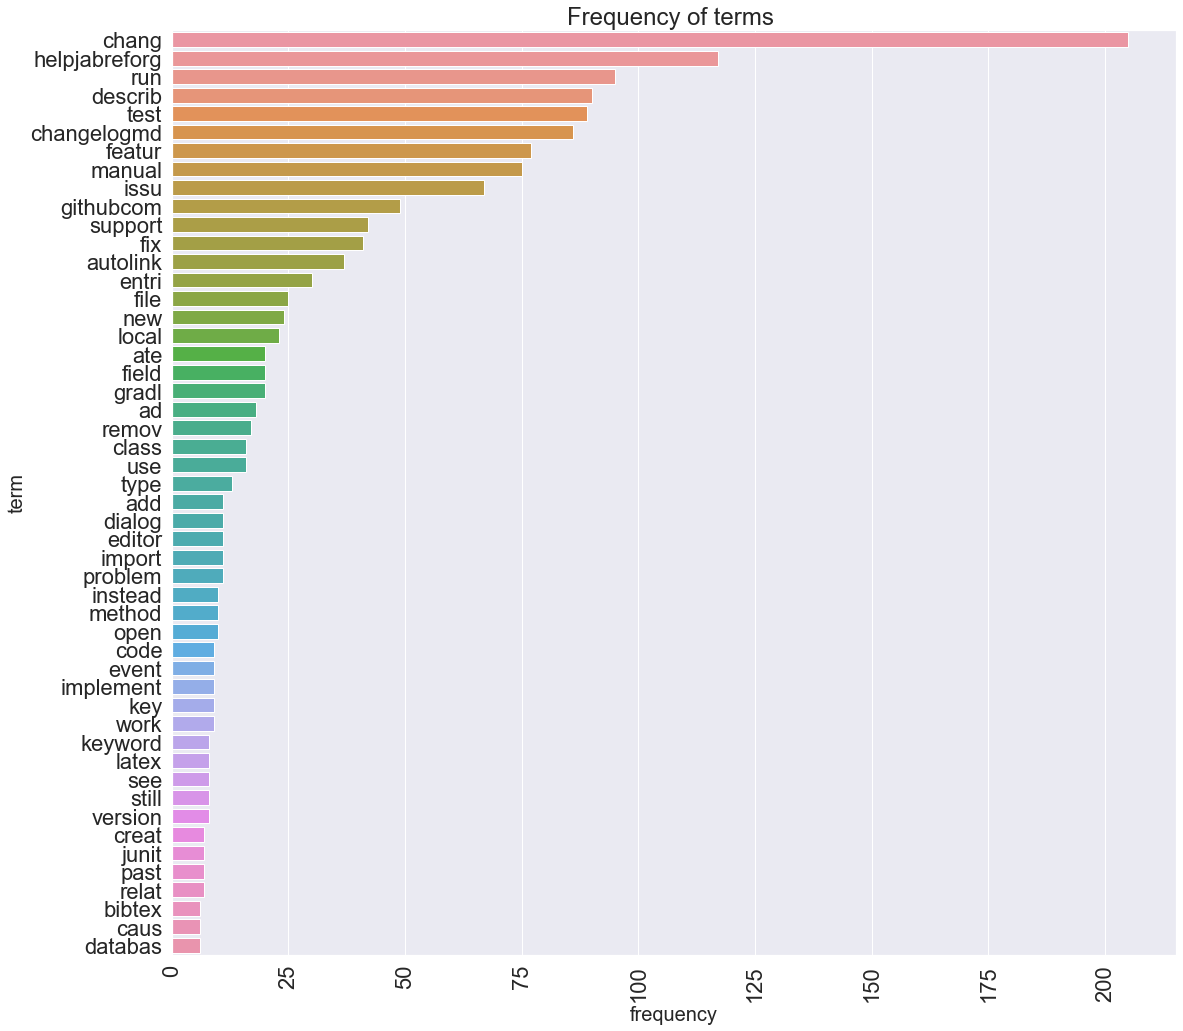

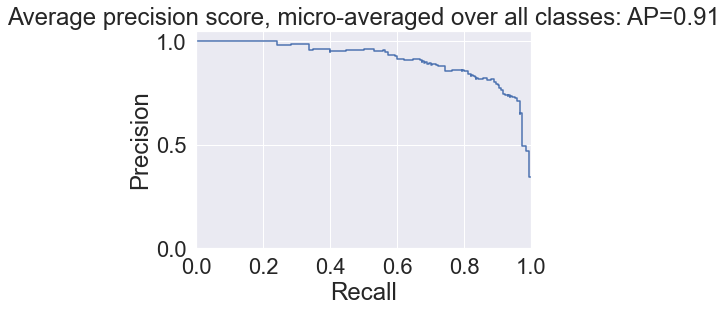

In [36]:
__main__()
